# Data Preprocessing

We pick up where we left off by importing the cleaned BookEDA dataset and re-acquanting ourselves with the variables present in the data.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import re

# library to convert contries to continents
import pycountry
import pycountry_convert as pc

from scipy import stats

In [2]:
# Read in the data and refresh our memories
df = pd.read_csv('../data/BooksEDA.csv', index_col=0)

In [3]:
df.head()

,user_id,age,isbn,rating,book_title,book_author,year_of_publication,publisher,language,city,state,country,category
0,2,18.0000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,en,stockton,california,usa,science & technology
1,8,34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,timmins,ontario,canada,unknown_category
2,11400,49.0000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,ottawa,ontario,canada,unknown_category
4,41385,34.7439,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,sudbury,ontario,canada,unknown_category
5,67544,30.0000,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,toronto,ontario,canada,unknown_category


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 982278 entries, 0 to 1031174
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              982278 non-null  int64  
 1   age                  982278 non-null  float64
 2   isbn                 982278 non-null  object 
 3   rating               982278 non-null  int64  
 4   book_title           982278 non-null  object 
 5   book_author          982278 non-null  object 
 6   year_of_publication  982278 non-null  float64
 7   publisher            982278 non-null  object 
 8   language             982278 non-null  object 
 9   city                 982278 non-null  object 
 10  state                982278 non-null  object 
 11  country              982278 non-null  object 
 12  category             982278 non-null  object 
dtypes: float64(2), int64(2), object(9)
memory usage: 104.9+ MB


In [5]:
df.isna().sum()

user_id                0
age                    0
isbn                   0
rating                 0
book_title             0
book_author            0
year_of_publication    0
publisher              0
language               0
city                   0
state                  0
country                0
category               0
dtype: int64

## Basic models that we will create

1. **Logistic Regression**  
   - Purpose: To predict the likelihood of users leaving a review.  
   - Output: Probability of whether a user will leave a review or not.  

2. **Decision Tree**  
   - Purpose: To classify reviews as positive or negative based on features.  
   - Output: A clear decision-making framework to determine the sentiment of reviews.  

## Preprocessing
As we can see, even though our data is clean, we are dealing with a large number of categorical values (stored as object type in pandas). We will somehow convert these values to numerical representations such that we can apply statistical modeling. 

During the preprocessing stage, we will maintain two separate dataframes:

1. **`df`**: The clean, preprocessed dataframe with original features for reference and analysis.  
2. **`df_encoded`**: The encoded version of the dataframe, where categorical variables and other features are transformed into a format suitable for modeling.

This approach ensures flexibility by preserving the raw data while enabling us to work seamlessly with the encoded data for building models.

## Country, state and city

For our models, we will work with continent-level data rather than focusing solely on U.S. states. This broader geographic categorization allows us to capture global patterns and reduces complexity, making our model more generalizable and easier to interpret.

To reduce the number of unique values in our `country` column, we will transform each country into its corresponding continent. This approach simplifies our data by grouping countries into broader categories, making it easier to analyze patterns across regions.

In [6]:
df['country'].value_counts()

country
usa                     742313
canada                   92461
united kingdom           30453
germany                  27255
australia                18191
                         ...  
ventura county               1
lkjlj                        1
ouranos                      1
victoria, australia          1
päijät-häme, finland         1
Name: count, Length: 394, dtype: int64

In [7]:
# takes a country name as an argument and returns the name of the continent that the country belongs to
def country_to_continent(country_name):
    try:
        country_alpha2 = pycountry.countries.lookup(country_name).alpha_2
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return None

In [8]:
df['continent'] = df['country'].apply(country_to_continent)

In [9]:
df['continent'].value_counts()

continent
North America    836650
Europe           107638
Oceania           23411
Asia               9534
South America      1317
Africa              309
Name: count, dtype: int64

In [10]:
df['continent'].isnull().sum()

3419

Since 3,419 rows represent a small percentage of our dataset (out of 982,278 rows), we can safely drop these rows with irregular or unrecognized `country` values. This step will help maintain data quality without significantly impacting the overall analysis.

In [11]:
df = df.dropna(subset=['continent'])

#### Visualization and Insights

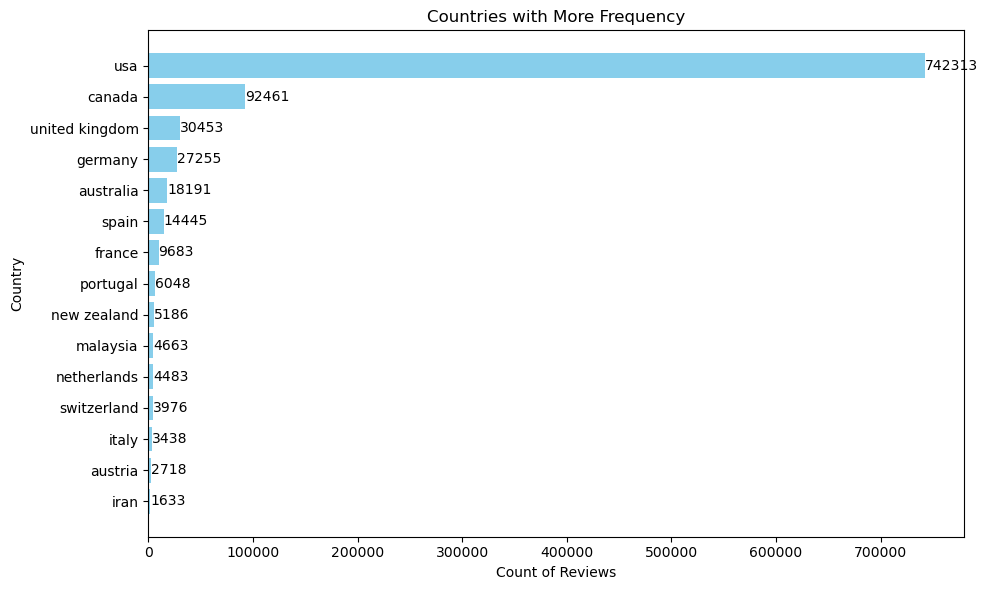

In [12]:
# Get the frequencies of the countries
country_counts = df['country'].value_counts().head(15)

# Create a bar chart with publishers on the y-axis and their counts on the x-axis
plt.figure(figsize=(10, 6))
plt.barh(country_counts.index, country_counts.values, color='skyblue')
plt.xlabel('Count of Reviews')
plt.ylabel('Country')
plt.title('Countries with More Frequency')
plt.gca().invert_yaxis() 

# Customize layout
for i, value in enumerate(country_counts.values):
    plt.text(value + 5, i, str(value), va='center')

plt.tight_layout()
plt.show()


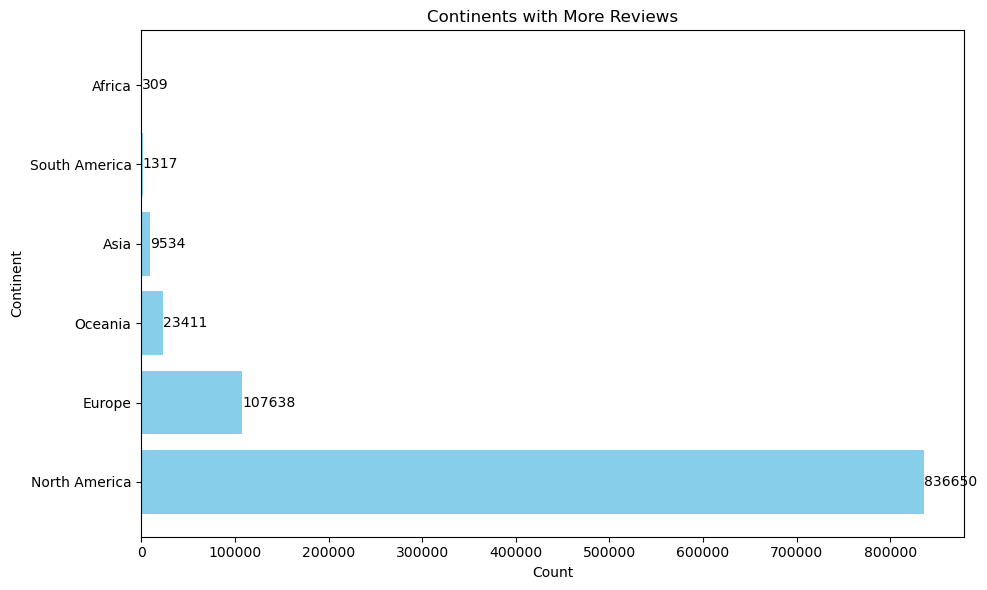

In [13]:
category_counts = df['continent'].value_counts()

# Create a horizontal bar chart with matplotlib
plt.figure(figsize=(10, 6))
plt.barh(category_counts.index, category_counts.values, color='skyblue')
plt.xlabel('Count')
plt.ylabel('Continent')
plt.title('Continents with More Reviews')

# Add values on the bars
for i, value in enumerate(category_counts.values):
    plt.text(value + 5, i, str(value), va='center')

plt.tight_layout()
plt.show()

By grouping by Continents we will help our models to identify broader trends and patterns (e.g., user engagement levels, reading habits, or popular genres) across regions rather than being hyper-focused on specific countries.

In this case the country USA (with a disproportionately high review count) can overshadow smaller nations. Grouping countries into continents balances this by pooling data, making smaller contributors more visible within their regional context.

Insights:

North America accounts for 836,650 reviews, far surpassing all other continents. This mirrors the large contributions from the USA and Canada in the first chart.

Underrepresented regions like Africa, South America, and parts of Asia present opportunities for expansion, either by engaging users in those regions or including more books from those areas.

### One-hot encoding for continents

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 978859 entries, 0 to 1031174
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              978859 non-null  int64  
 1   age                  978859 non-null  float64
 2   isbn                 978859 non-null  object 
 3   rating               978859 non-null  int64  
 4   book_title           978859 non-null  object 
 5   book_author          978859 non-null  object 
 6   year_of_publication  978859 non-null  float64
 7   publisher            978859 non-null  object 
 8   language             978859 non-null  object 
 9   city                 978859 non-null  object 
 10  state                978859 non-null  object 
 11  country              978859 non-null  object 
 12  category             978859 non-null  object 
 13  continent            978859 non-null  object 
dtypes: float64(2), int64(2), object(10)
memory usage: 112.0+ MB


In [15]:
# Drop the categories that we are not going to use
df.drop(columns=['city','state','country'], inplace=True)

After mapping and cleaning, we've reduced the original 394 unique `country` values down to 6 continent-based categories. This transformation provides clearer indicators of regional data trends and makes encoding much simpler, allowing for more efficient analysis and modeling.

In [16]:
pd.get_dummies(df['continent'], dtype='int')

,Africa,Asia,Europe,North America,Oceania,South America
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,0,0,0,1,0,0
4,0,0,0,1,0,0
5,0,0,0,1,0,0
...,...,...,...,...,...,...
1031170,0,0,0,1,0,0
1031171,0,0,0,1,0,0
1031172,0,0,0,1,0,0
1031173,0,0,0,1,0,0


In [17]:
# Apply one-hot encoding
continent_dummies = pd.get_dummies(df['continent'], dtype='int')

# Creation of new DF,  Concatenate the dummy variables with the original DataFrame
df_encoded = pd.concat([df, continent_dummies], axis=1)

df_encoded = df_encoded.drop(columns=['continent'], axis=1)

In [18]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 978859 entries, 0 to 1031174
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              978859 non-null  int64  
 1   age                  978859 non-null  float64
 2   isbn                 978859 non-null  object 
 3   rating               978859 non-null  int64  
 4   book_title           978859 non-null  object 
 5   book_author          978859 non-null  object 
 6   year_of_publication  978859 non-null  float64
 7   publisher            978859 non-null  object 
 8   language             978859 non-null  object 
 9   category             978859 non-null  object 
 10  Africa               978859 non-null  int32  
 11  Asia                 978859 non-null  int32  
 12  Europe               978859 non-null  int32  
 13  North America        978859 non-null  int32  
 14  Oceania              978859 non-null  int32  
 15  South America        

## Book Authors

### Frequency Encoding

We will use **Frequency Encoding** to transform categorical variables, in this case authors, into numerical values based on their frequency in the dataset. This encoding can help us analyze whether popular authors correlate with higher (or lower) ratings, depending on the data patterns.

In [19]:
# Calculate frequency for each unique author
author_frequencies = df['book_author'].value_counts()

# Map the frequencies back to the original column
df['author_frequency'] = df['book_author'].map(author_frequencies)

# Add the column to df_encoded
df_encoded['author_frequency'] = df['author_frequency']

# Sanity Check
df['author_frequency'].value_counts()

author_frequency
1      49037
2      32754
3      23907
4      19152
5      15830
       ...  
233      233
221      221
210      210
192      192
147      147
Name: count, Length: 635, dtype: int64

In [20]:
df.head()

,user_id,age,isbn,rating,book_title,book_author,year_of_publication,publisher,language,category,continent,author_frequency
0,2,18.0000,0195153448,0,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,en,science & technology,North America,2
1,8,34.7439,0002005018,5,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,unknown_category,North America,13
2,11400,49.0000,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,unknown_category,North America,13
4,41385,34.7439,0002005018,0,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,unknown_category,North America,13
5,67544,30.0000,0002005018,8,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,en,unknown_category,North America,13


#### Visualizations and Insights

In [21]:
df['author_frequency'].value_counts()

author_frequency
1      49037
2      32754
3      23907
4      19152
5      15830
       ...  
233      233
221      221
210      210
192      192
147      147
Name: count, Length: 635, dtype: int64

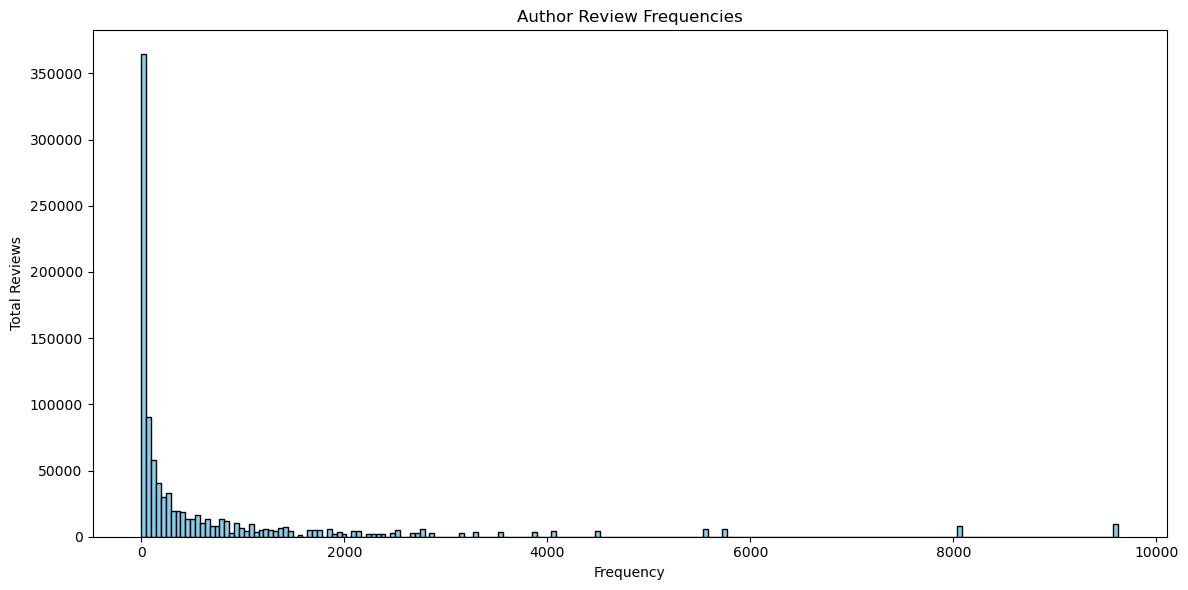

In [22]:
plt.figure(figsize=(12, 6))
plt.hist(df['author_frequency'], bins=200, color='skyblue', edgecolor='black')
plt.title('Author Review Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Total Reviews')

plt.tight_layout()
plt.show()

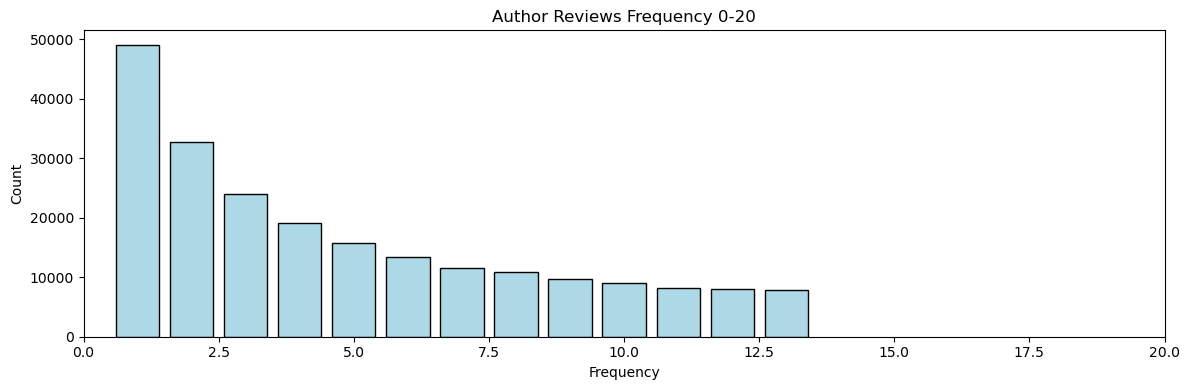

In [23]:
# Sample the top 15 authors by frequency
sample = df['author_frequency'].value_counts().sort_values(ascending=False).head(15)

# Create a bar chart with author ratings on x-axis and their counts on y-axis
plt.figure(figsize=(12, 4))
plt.bar(sample.index, sample.values, color='lightblue', edgecolor='black')
plt.title('Author Reviews Frequency 0-20')
plt.xlabel('Frequency')
plt.ylabel('Count')
plt.gca().set_xlim([0, 20])


# Show the chart
plt.tight_layout()
plt.show()

The data suggests that the majority of authors do not receive high engagement, indicating either limited popularity, low discoverability, or possibly a large number of authors in genres or niches with smaller audiences.

For authors with only 1 or 2 reviews, there might be opportunities to increase visibility, such as through targeted recommendations, genre-based promotions, or highlighting them alongside more popular books.

The long tail extending to very high frequencies (e.g., 5,000–9,000 reviews) highlights a few highly popular or prolific authors. These outliers may represent best-selling authors or authors with large catalogs of books.

### Target Encoding

We will use **Target Encoding** to capture the average rating for each author. This technique calculates the mean of the target variable (`rating`) grouped by a categorical feature (`book_author`) and maps it back to the dataset. 

### Calculate Implicit Reviews Encoding

To account for **implicit feedback**, we will calculate the proportion of implicit interactions for cases where `rating == 0`. This represents the percentage of times a book was interacted with (e.g., viewed or clicked) without an explicit rating being provided. 


In [24]:
# Filter implicit feedback (rating == 0)
implicit_df = df[df['rating'] == 0]

# Calculate the total reviews and implicit interactions for each author
author_total_reviews = df.groupby('book_author')['rating'].count()  # Total reviews (all ratings)
author_implicit_reviews = implicit_df['book_author'].value_counts()  # Total implicit reviews (rating == 0)

# Calculate the proportion of implicit interactions for each author
author_implicit_proportion = author_implicit_reviews / author_total_reviews

# Map the proportions back to the main DataFrame
df['author_implicit_encoded'] = df['book_author'].map(author_implicit_proportion)

# Fill missing values with 0 (for authors with no implicit interactions)
df['author_implicit_encoded'].fillna(0, inplace=True)

# Add the column to df_encoded

df_encoded['author_implicit_encoded'] = df['author_implicit_encoded']

#### Visualization and insights

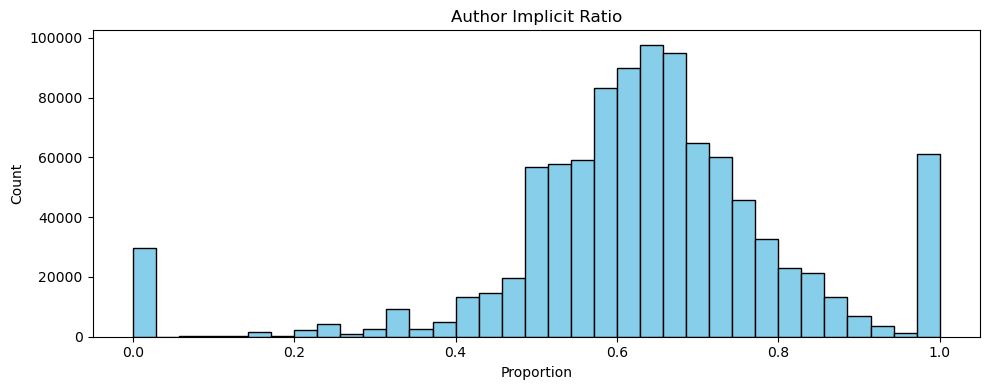

In [25]:
plt.figure(figsize=(10, 4))
plt.hist(df['author_implicit_encoded'], bins=35, color='skyblue', edgecolor='black')
plt.title('Author Implicit Ratio')
plt.xlabel('Proportion')
plt.ylabel('Count')

# Show the chart
plt.tight_layout()
plt.show()

The histogram indicates that many authors have a moderate proportion of implicit interactions (centered around ~0.6). This suggests that for these authors, a significant portion of their ratings on the dataframe comes from implicit feedback rather than explicit ratings.

Authors with author_implicit_encoded values close to 0 likely have very few implicit interactions or a higher proportion of explicit ratings. These could be well-known authors with many explicit reviews or lesser-known ones with fewer overall interactions.

The spike near author_implicit_encoded = 1 suggests there are authors whose interactions are almost entirely implicit, otherwise for the spike near 0

### Explicit Reviews encoding

To capture the **mean reviews per author**, we will focus only on explicit reviews (`rating > 0`). By grouping the data based on explicit reviews, we can calculate the average rating for each author and append this information to the dataframe.

In [26]:
# Filter explicit reviews (rating > 0)
explicit_df = df[df['rating'] > 0]

# Calculate mean explicit rating for each author
author_explicit_mean_rating = explicit_df.groupby('book_author')['rating'].mean()

# Map mean explicit ratings back to the main DataFrame
df['author_explicit_encoded'] = df['book_author'].map(author_explicit_mean_rating)

df['author_explicit_encoded'].value_counts()

author_explicit_encoded
8.000000     36803
7.000000     30028
9.000000     16383
7.500000     16329
10.000000    14742
             ...  
5.300000        10
1.666667         8
2.333333         6
4.400000         6
2.666667         4
Name: count, Length: 1801, dtype: int64

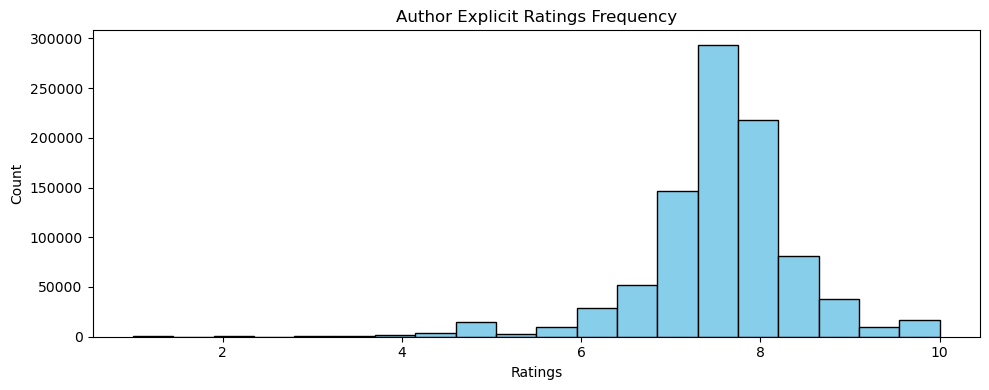

In [27]:
plt.figure(figsize=(10, 4))
plt.hist(df['author_explicit_encoded'], bins=20, color='skyblue', edgecolor='black')
plt.title('Author Explicit Ratings Frequency')
plt.xlabel('Ratings')
plt.ylabel('Count')

# Show the chart
plt.tight_layout()
plt.show()

In [28]:
df['author_explicit_encoded'].isna().sum()

60999

In [29]:
# for the null cases (where the authors only have implicit reviews) we are going to assign them the median.

In [30]:
df['author_explicit_encoded'].fillna(explicit_df['rating'].mean(), inplace=True)

# Add the column to df_encoded
df_encoded['author_explicit_encoded'] = df['author_explicit_encoded']

df['author_explicit_encoded'].isna().sum()


0

#### Visualization and insights

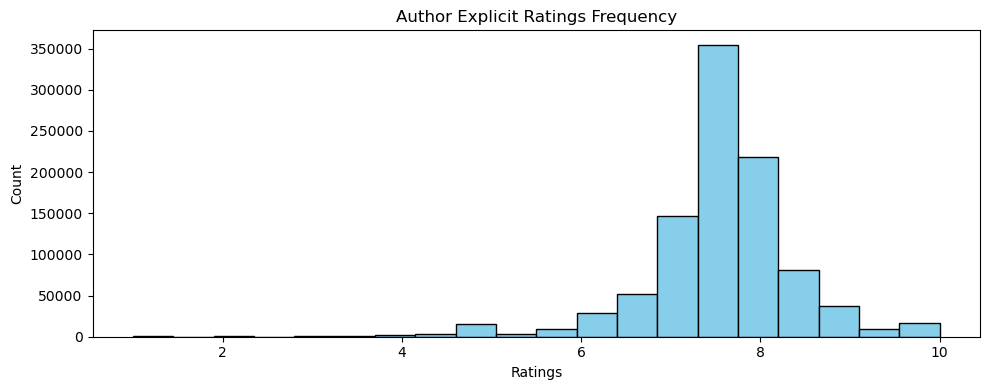

In [31]:
plt.figure(figsize=(10, 4))
plt.hist(df['author_explicit_encoded'], bins=20, color='skyblue', edgecolor='black')
plt.title('Author Explicit Ratings Frequency')
plt.xlabel('Ratings')
plt.ylabel('Count')

# Show the chart
plt.tight_layout()
plt.show()

The distribution is centered around a rating of 7, where the highest count of explicit ratings occurs. This suggests that most users tend to give authors relatively positive ratings.

Ratings in the range of 1–4 are minimal, showing that users either rarely assign such low scores or that books/authors in this dataset generally receive favorable feedback.

Bias Towards Positive Ratings: The data indicates a tendency for users to favor higher ratings, which could be due to a positive bias or a preference for rating only books they enjoyed.

### Average of All Reviews Authors

In [32]:
# Average of all reviews (including implicit feedback)
author_mean_rating_all = df.groupby('book_author')['rating'].mean()
df['author_avg_all_reviews'] = df['book_author'].map(author_mean_rating_all)

# Add the column to df_encoded
df_encoded['author_avg_all_reviews'] = df['author_avg_all_reviews']

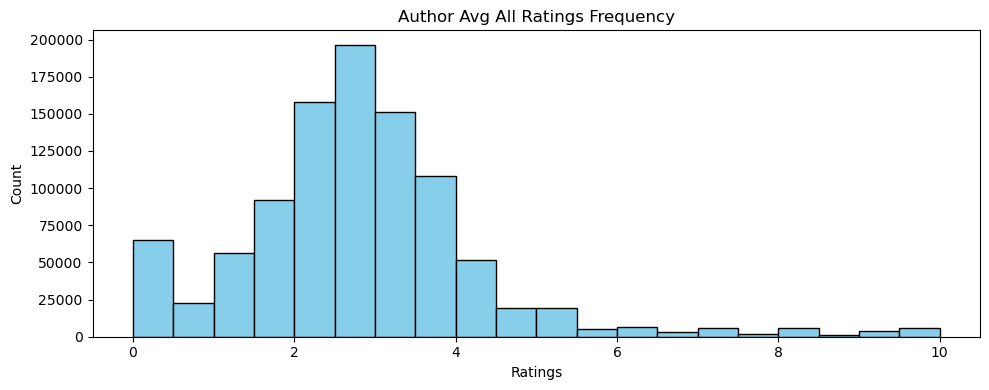

In [33]:
plt.figure(figsize=(10, 4))
plt.hist(df['author_avg_all_reviews'], bins=20, color='skyblue', edgecolor='black')
plt.title('Author Avg All Ratings Frequency')
plt.xlabel('Ratings')
plt.ylabel('Count')

# Show the chart
plt.tight_layout()
plt.show()

The distribution peaks around an average rating of 2 an 3, indicating that the majority of authors have relatively low average ratings when implicit feedback is included.

The distribution has a significant drop-off as the average rating increases beyond 4. Higher average ratings (6–10) are rare, which might indicate that implicit interactions typically dilute overall ratings compared to explicit ratings alone.

Including implicit reviews in the average ratings likely provides a more balanced view of user engagement. Explicit ratings alone tend to skew higher (as seen in the previous chart), while implicit reviews seem to moderate these averages.

In [34]:
# Drop book_author column for encoded dataframe
df_encoded = df_encoded.drop(columns=['book_author'], axis=1)

In [35]:
df_encoded.head()

,user_id,age,isbn,rating,book_title,year_of_publication,publisher,language,category,Africa,Asia,Europe,North America,Oceania,South America,author_frequency,author_implicit_encoded,author_explicit_encoded,author_avg_all_reviews
0,2,18.0000,0195153448,0,Classical Mythology,2002.0,Oxford University Press,en,science & technology,0,0,0,1,0,0,2,0.500000,7.000000,3.5
1,8,34.7439,0002005018,5,Clara Callan,2001.0,HarperFlamingo Canada,en,unknown_category,0,0,0,1,0,0,13,0.461538,7.428571,4.0
2,11400,49.0000,0002005018,0,Clara Callan,2001.0,HarperFlamingo Canada,en,unknown_category,0,0,0,1,0,0,13,0.461538,7.428571,4.0
4,41385,34.7439,0002005018,0,Clara Callan,2001.0,HarperFlamingo Canada,en,unknown_category,0,0,0,1,0,0,13,0.461538,7.428571,4.0
5,67544,30.0000,0002005018,8,Clara Callan,2001.0,HarperFlamingo Canada,en,unknown_category,0,0,0,1,0,0,13,0.461538,7.428571,4.0


#### Summary Author Encoding

- Frequency: Number of reviews per author, serving as a measure for scale.
- Implicit encoded: Proportion of implicit interactions (rating == 0) for the author. Useful for capturing engagement signals or as a proxy for popularity.
- Average All Reviews: Combines average of implicit and explicit ratings. It gives a well-rounded view that might reflect how popular or well-liked an author is.
- Explicit encoded: Focuses only on average of explicit ratings (rating > 0). Strongly indicative of quality or satisfaction, especially when predicting user preferences.

## Publisher Encoding

### Frequency Encoding

We will use Frequency Encoding to transform the `Publisher` column into numerical values based on their frequency in the dataset, similar to how it was applied to the `Author` column. By assigning values according to the occurrence of each publisher, we can analyze whether the popularity of publishers correlates with higher (or lower) ratings, depending on the data patterns.

In [36]:
# Calculate frequency for each unique author
publisher_frequencies = df['publisher'].value_counts()

# Map the frequencies back to the original column
df['publisher_frequency'] = df['publisher'].map(publisher_frequencies)

# Add the column to df_encoded
df_encoded['publisher_frequency'] = df['publisher_frequency']

# Sanity Check
df['publisher_frequency'].value_counts().head()

publisher_frequency
32988    32988
30543    30543
27270    27270
24452    24452
24214    24214
Name: count, dtype: int64

#### Visualization and Insights

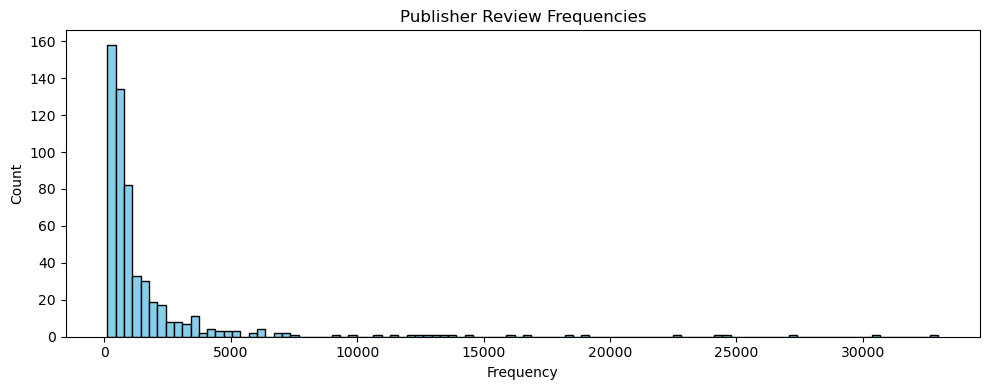

In [37]:
plt.figure(figsize=(10, 4))
plt.hist(df['publisher_frequency'].value_counts(), bins=100, color='skyblue', edgecolor='black')
plt.title('Publisher Review Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Count')

# Show the chart
plt.tight_layout()
plt.show()

We can see a prevalence of a small number of reviews per publisher in the database with a significant tail extends toward publishers with higher review frequencies (15,000–30,000+ reviews). These represent a few highly popular publishers that dominate user engagement and feedback.

This distribution could provide valuable insights for the models, as they may identify a relationship between the frequency of reviews and the tendency of those reviews (e.g., positive or negative). By incorporating this information, the models could better understand how the volume of reviews for a publisher influences user ratings and feedback patterns.

### Target encoding

Considering that publishers often have distinct reputations (e.g., some focus on quality literature, while others might publish mass-market content). It may be useful to see the individual ratings for each publishers as we did with authors. This new columns could reveal patterns or trends that highlight whether certain publishers consistently receive higher or lower ratings, helping the model better understand the impact of publisher reputation on reviews.

### Calculate Implicit Reviews Encoding

We will use Target Encoding to capture the average rating for each publisher. This technique calculates the mean of the target variable (rating) grouped by a categorical feature (publisher) and maps it back to the dataset. 

In [38]:
# Filter implicit feedback (rating == 0)
implicit_df = df[df['rating'] == 0]

# Calculate the total reviews and implicit interactions for each author
publisher_total_reviews = df.groupby('publisher')['rating'].count()  # Total reviews (all ratings)
publisher_implicit_reviews = implicit_df['publisher'].value_counts()  # Total implicit reviews (rating == 0)

# Calculate the proportion of implicit interactions for each author
publisher_implicit_proportion = publisher_implicit_reviews / publisher_total_reviews

# Map the proportions back to the main DataFrame
df['publisher_implicit_encoded'] = df['publisher'].map(publisher_implicit_proportion)

# Fill missing values with 0 (for authors with no implicit interactions)
df['publisher_implicit_encoded'].fillna(0, inplace=True)

# Add the column to df_encoded

df_encoded['publisher_implicit_encoded'] = df['publisher_implicit_encoded']

#### Visualization and Insights

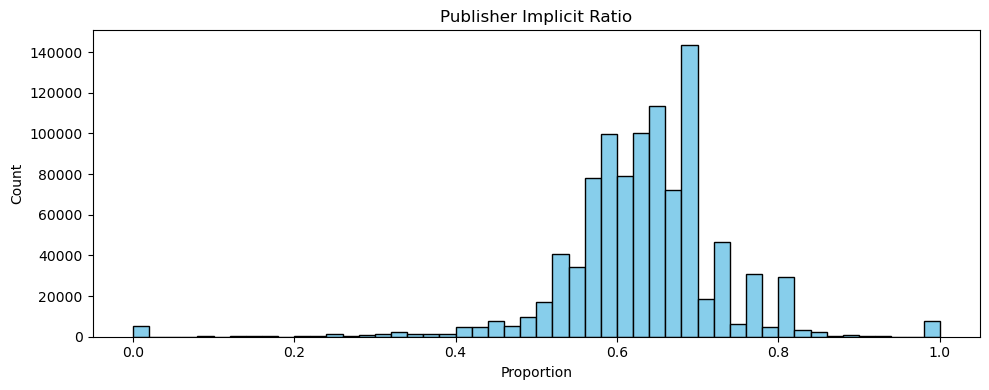

In [39]:
plt.figure(figsize=(10, 4))
plt.hist(df['publisher_implicit_encoded'], bins=50, color='skyblue', edgecolor='black')
plt.title('Publisher Implicit Ratio')
plt.xlabel('Proportion')
plt.ylabel('Count')

# Show the chart
plt.tight_layout()
plt.show()

The majority of publishers have an implicit ratio between 0.6 and 0.8. This indicates that implicit reviews dominate, constituting 60% to 80% of the total reviews for most publishers. The distribution skews slightly to the right, emphasizing that publishers often rely more heavily on implicit ratings than explicit ones.

### Calculate Explicit Reviews Encoding

To capture the mean reviews per publisher, we will focus only on explicit reviews (rating > 0). By grouping the data based on explicit reviews, we can calculate the average rating for each publisher and append this information to the dataframe.

In [40]:
# Filter explicit reviews (rating > 0)
explicit_df = df[df['rating'] > 0]

# Calculate mean explicit rating for each author
publisher_explicit_mean_rating = explicit_df.groupby('publisher')['rating'].mean()

# Map mean explicit ratings back to the main DataFrame
df['publisher_explicit_encoded'] = df['publisher'].map(publisher_explicit_mean_rating)

df['publisher_explicit_encoded'].value_counts()

publisher_explicit_encoded
7.605043    32988
7.572321    30543
7.449518    27270
7.183622    24452
7.546411    24214
            ...  
5.222222        9
2.500000        7
5.571429        7
5.166667        6
3.666667        4
Name: count, Length: 1152, dtype: int64

In [41]:
df['publisher_explicit_encoded'].isna().sum()

7799

In [42]:
# for the null cases we are going to assign them the median as assigning them to 0 would misrepresent the data, implying that they are explicitly low ratings.
df['publisher_explicit_encoded'].fillna(explicit_df['rating'].mean(), inplace=True)

# Add the column to df_encoded
df_encoded['publisher_explicit_encoded'] = df['publisher_explicit_encoded']

df['publisher_explicit_encoded'].isna().sum()

0

#### Visualization and Insight

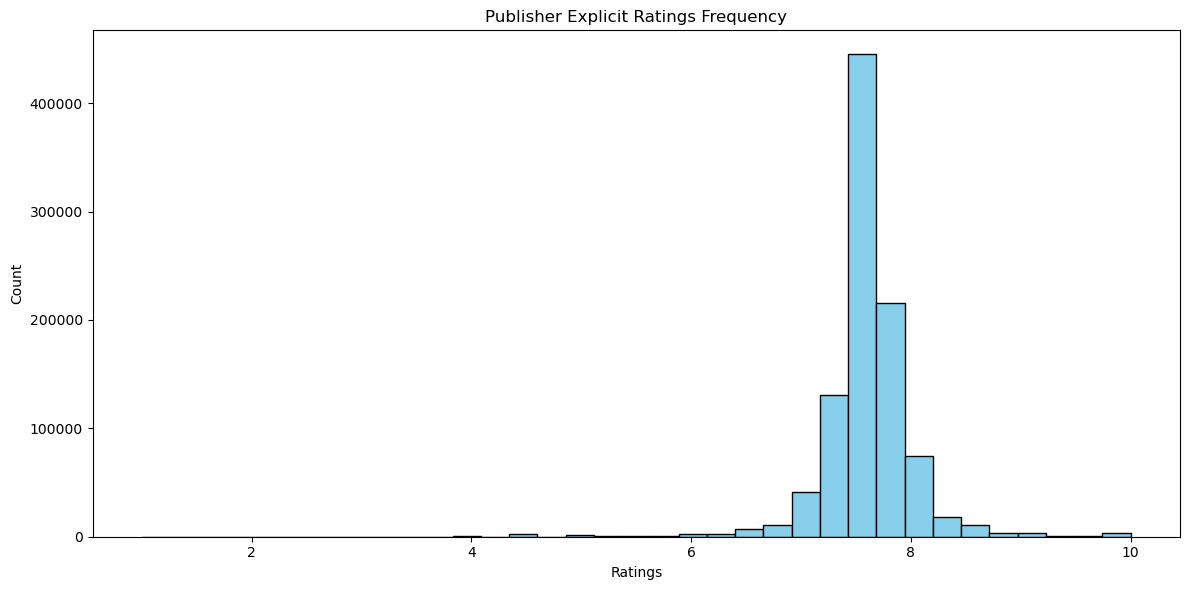

In [43]:
plt.figure(figsize=(12, 6))
plt.hist(df['publisher_explicit_encoded'], bins=35, color='skyblue', edgecolor='black')
plt.title('Publisher Explicit Ratings Frequency')
plt.xlabel('Ratings')
plt.ylabel('Count')

# Show the chart
plt.tight_layout()
plt.show()

The majority of explicit ratings are clustered around the higher end of the scale, particularly between 7 and 8. This suggests that most explicit feedback is positive or very favorable.

### Average of All Reviews Publisher

In [44]:
# Average of all reviews (including implicit feedback)
publisher_mean_rating_all = df.groupby('publisher')['rating'].mean()
df['publisher_avg_all_reviews'] = df['publisher'].map(publisher_mean_rating_all)

# Add the column to df_encoded
df_encoded['publisher_avg_all_reviews'] = df['publisher_avg_all_reviews']

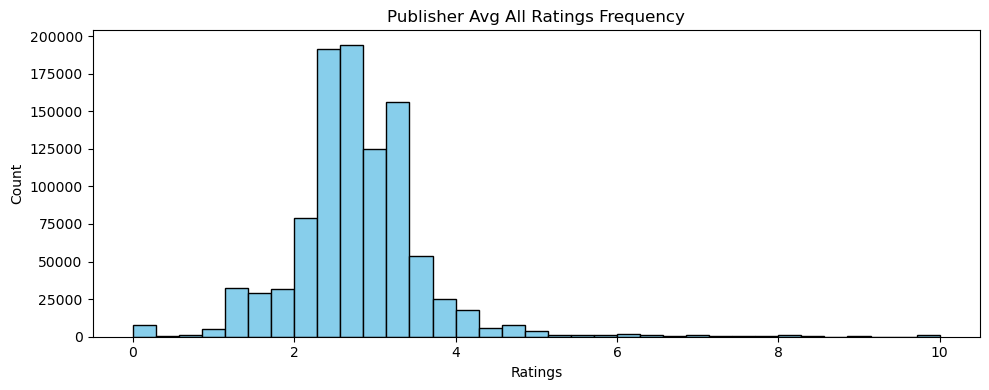

In [45]:
plt.figure(figsize=(10, 4))
plt.hist(df['publisher_avg_all_reviews'], bins=35, color='skyblue', edgecolor='black')
plt.title('Publisher Avg All Ratings Frequency')
plt.xlabel('Ratings')
plt.ylabel('Count')

# Show the chart
plt.tight_layout()
plt.show()

The distribution appears closer to a normal curve, with the majority of average ratings falling between 2 and 4. Furthermore, the clustering of ratings between 2 and 4 is heavily influenced by the inclusion of implicit reviews. Since most reviews are implicit, they dominate the overall average, diluting the impact of explicit ratings.

In [46]:
# drop publisher column for encoded dataframe
df_encoded = df_encoded.drop(columns=['publisher'], axis=1)

In [47]:
df_encoded.head()

,user_id,age,isbn,rating,book_title,year_of_publication,language,category,Africa,Asia,...,Oceania,South America,author_frequency,author_implicit_encoded,author_explicit_encoded,author_avg_all_reviews,publisher_frequency,publisher_implicit_encoded,publisher_explicit_encoded,publisher_avg_all_reviews
0,2,18.0000,0195153448,0,Classical Mythology,2002.0,en,science & technology,0,0,...,0,0,2,0.500000,7.000000,3.5,2542,0.564123,7.750000,3.378049
1,8,34.7439,0002005018,5,Clara Callan,2001.0,en,unknown_category,0,0,...,0,0,13,0.461538,7.428571,4.0,45,0.533333,7.333333,3.422222
2,11400,49.0000,0002005018,0,Clara Callan,2001.0,en,unknown_category,0,0,...,0,0,13,0.461538,7.428571,4.0,45,0.533333,7.333333,3.422222
4,41385,34.7439,0002005018,0,Clara Callan,2001.0,en,unknown_category,0,0,...,0,0,13,0.461538,7.428571,4.0,45,0.533333,7.333333,3.422222
5,67544,30.0000,0002005018,8,Clara Callan,2001.0,en,unknown_category,0,0,...,0,0,13,0.461538,7.428571,4.0,45,0.533333,7.333333,3.422222


### Publisher Encoding Summary 
- Frequency encoded: Number of books or interactions per publisher. Reflects publisher scale.
- Implicit encoded: Proportion of implicit interactions (rating == 0) per publisher. Useful for capturing engagement signals or as a proxy for popularity.
- Explicit encoded: Average of explicit ratings (rating > 0) per publisher. Strongly indicative of quality or satisfaction.
- Average All Reviews: Combines the average of implicit and explicit ratings. Provides a well-rounded view of how publishers are perceived overall.

## Language encoding


To encode the language column, I plan to group less common languages together with the "NA" values under a single category labeled as "unknown." The more frequently occurring languages will be retained as individual categories, allowing for one-hot encoding to be applied later.

In [48]:
df['language'].value_counts()

language
en       588439
na       377911
de         5321
es         3171
fr         2815
it          647
nl          212
da          108
pt           79
ca           41
ru           23
ms           11
gl           11
no           10
la            9
zh-CN         8
th            6
ja            6
el            5
ga            4
vi            3
ar            3
ro            2
fa            2
eo            2
gd            2
zh-TW         2
pl            1
tl            1
cy            1
hi            1
ko            1
sv            1
Name: count, dtype: int64

In [49]:
language_counts = df['language'].value_counts()

In [50]:
df['language_grouped'] = df['language'].apply(
    lambda x: x if language_counts[x] > 500 else 'unknown_lg'
)

In [51]:
df['language_grouped'] = df['language_grouped'].replace(['na'], 'unknown_lg')

In [52]:
df['language_grouped'].value_counts()

language_grouped
en            588439
unknown_lg    378466
de              5321
es              3171
fr              2815
it               647
Name: count, dtype: int64

In [53]:
# Apply one-hot encoding
continent_dummies = pd.get_dummies(df['language_grouped'], dtype='int')

# Concatenate the dummy variables with the original DataFrame
df_encoded = pd.concat([df_encoded, continent_dummies], axis=1)

df_encoded = df_encoded.drop(columns=['language'], axis=1)

In [54]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 978859 entries, 0 to 1031174
Data columns (total 27 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   user_id                     978859 non-null  int64  
 1   age                         978859 non-null  float64
 2   isbn                        978859 non-null  object 
 3   rating                      978859 non-null  int64  
 4   book_title                  978859 non-null  object 
 5   year_of_publication         978859 non-null  float64
 6   category                    978859 non-null  object 
 7   Africa                      978859 non-null  int32  
 8   Asia                        978859 non-null  int32  
 9   Europe                      978859 non-null  int32  
 10  North America               978859 non-null  int32  
 11  Oceania                     978859 non-null  int32  
 12  South America               978859 non-null  int32  
 13  author_frequency  

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 978859 entries, 0 to 1031174
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   user_id                     978859 non-null  int64  
 1   age                         978859 non-null  float64
 2   isbn                        978859 non-null  object 
 3   rating                      978859 non-null  int64  
 4   book_title                  978859 non-null  object 
 5   book_author                 978859 non-null  object 
 6   year_of_publication         978859 non-null  float64
 7   publisher                   978859 non-null  object 
 8   language                    978859 non-null  object 
 9   category                    978859 non-null  object 
 10  continent                   978859 non-null  object 
 11  author_frequency            978859 non-null  int64  
 12  author_implicit_encoded     978859 non-null  float64
 13  author_explicit_en

## Category encoding

The category column has already been grouped into the most common book categories based on related keywords, and one-hot encoding will be applied to this column.

In [56]:
df['category'].value_counts()

category
unknown_category           461468
fiction                    423425
non-fiction                 42688
science & technology        11992
art & culture                9334
religion & spirituality      9278
self-help                    7249
business & economics         5233
cookbooks                    3031
children's books             2663
poetry                       2451
health & fitness               47
Name: count, dtype: int64

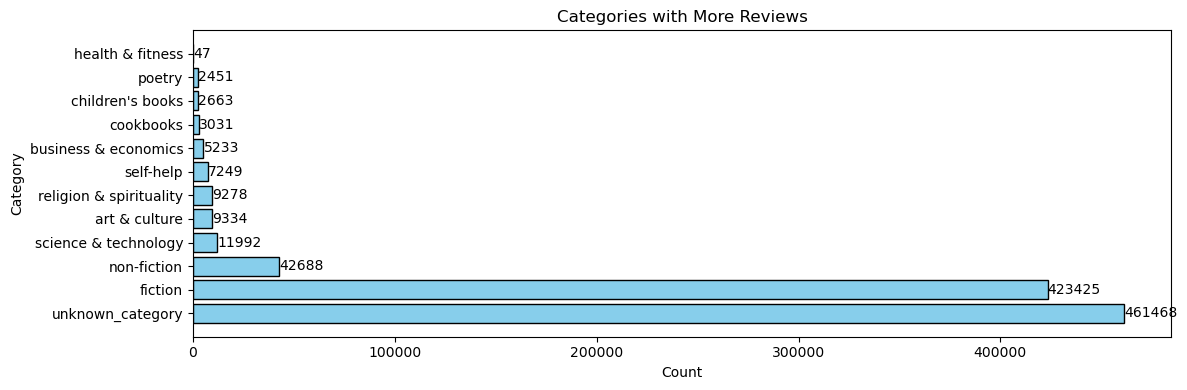

In [57]:
# Get the frequencies of the categories
category_counts = df['category'].value_counts()

# Create a horizontal bar chart
plt.figure(figsize=(12, 4))
plt.barh(category_counts.index, category_counts.values, color='skyblue', edgecolor='black')
plt.title('Categories with More Reviews')
plt.xlabel('Count')
plt.ylabel('Category')

# Add values to the bars
for i, value in enumerate(category_counts.values):
    plt.text(value + 5, i, str(value), va='center')

# Show the chart
plt.tight_layout()
plt.show()

The category column reveals a significant prevalence of unknown values. Following this, the fiction category has the highest number of reviews, and there is a substantial drop to the juvenile fiction category. This distribution underscores the challenge of analyzing category trends due to the high number of unknown entries.

In [58]:
# Apply one-hot encoding
category_dummies = pd.get_dummies(df['category'], dtype='int')

# Concatenate the dummy variables with the original DataFrame
df_encoded = pd.concat([df_encoded, category_dummies], axis=1)

df_encoded = df_encoded.drop(columns=['category'], axis=1)

In [59]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 978859 entries, 0 to 1031174
Data columns (total 38 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   user_id                     978859 non-null  int64  
 1   age                         978859 non-null  float64
 2   isbn                        978859 non-null  object 
 3   rating                      978859 non-null  int64  
 4   book_title                  978859 non-null  object 
 5   year_of_publication         978859 non-null  float64
 6   Africa                      978859 non-null  int32  
 7   Asia                        978859 non-null  int32  
 8   Europe                      978859 non-null  int32  
 9   North America               978859 non-null  int32  
 10  Oceania                     978859 non-null  int32  
 11  South America               978859 non-null  int32  
 12  author_frequency            978859 non-null  int64  
 13  author_implicit_en

## Book Title 

In [60]:
df.book_title.value_counts().describe()

count    235672.000000
mean          4.153480
std          16.063072
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        2365.000000
Name: count, dtype: float64

Considering that book title contains a High Cardinality I am going to drop it and that 75% of book titles appear 3 or fewer times. These rare values contribute little statistical or predictive value unless explicitly analyzed

In [61]:
df = df.drop(columns=['book_title'], axis=1)
df_encoded = df_encoded.drop(columns=['book_title'], axis=1)

## User Id and ISBN

For the initial models we will be building, User ID and ISBN will not be needed since they are merely identifiers and do not have meaningful relationships with the target variable. Therefore, we will drop them for now.

In [62]:
df_encoded = df_encoded.drop(columns=['user_id','isbn'], axis=1)

## Exporting The Preprocessed Dataframes

## Modeling

In [63]:
X = df_encoded.drop('rating', axis=1)
y = df_encoded['rating'].copy()

In [64]:
X.columns

Index(['age', 'year_of_publication', 'Africa', 'Asia', 'Europe',
       'North America', 'Oceania', 'South America', 'author_frequency',
       'author_implicit_encoded', 'author_explicit_encoded',
       'author_avg_all_reviews', 'publisher_frequency',
       'publisher_implicit_encoded', 'publisher_explicit_encoded',
       'publisher_avg_all_reviews', 'de', 'en', 'es', 'fr', 'it', 'unknown_lg',
       'art & culture', 'business & economics', 'children's books',
       'cookbooks', 'fiction', 'health & fitness', 'non-fiction', 'poetry',
       'religion & spirituality', 'science & technology', 'self-help',
       'unknown_category'],
      dtype='object')

In [65]:
y

0           0
1           5
2           0
4           0
5           8
           ..
1031170     0
1031171     5
1031172     7
1031173     7
1031174    10
Name: rating, Length: 978859, dtype: int64

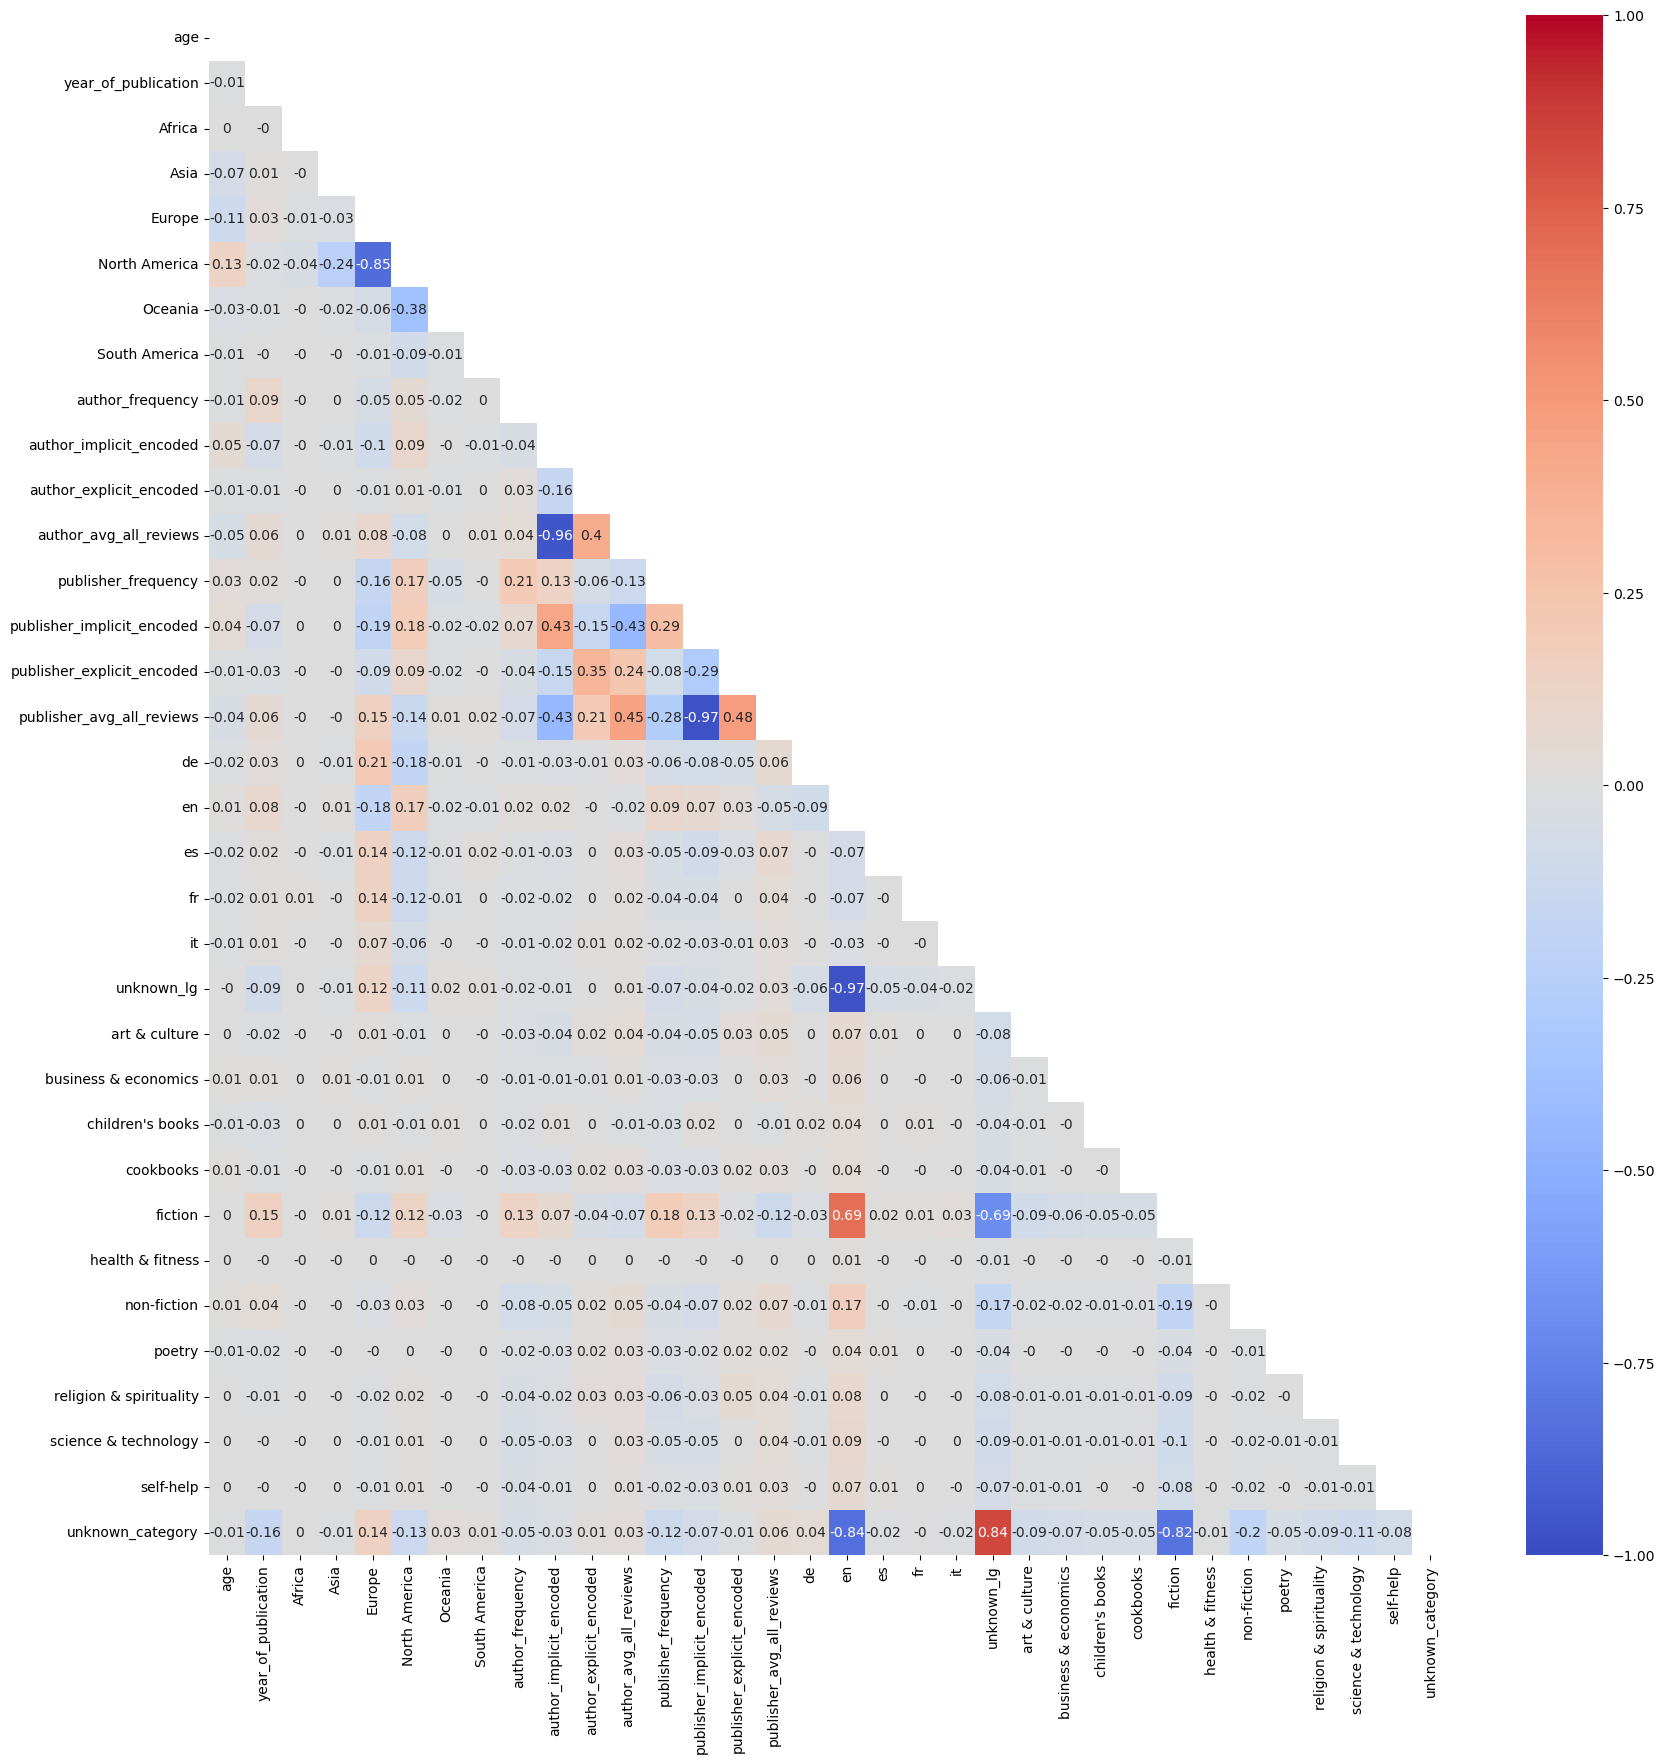

In [66]:
# Calculate all the correlations between each independent variable
corr_df = X.corr()

# Mask for upper triangular
mask = np.triu(corr_df)

# Visualize 
plt.figure(figsize=(20, 20))
sns.heatmap(corr_df.round(2), annot=True, vmax=1, vmin=-1, center=0, cmap='coolwarm', mask=mask)
plt.show()

## Logistic model 

Since logistic models predict values between 0 and 1, we will convert the ratings into implicit (0) and explicit (1) categories to predict whether users are likely to leave a review or not.

In [67]:
y = y.apply(lambda x: 1 if 1 <= x <= 10 else x)

In [68]:
y

0          0
1          1
2          0
4          0
5          1
          ..
1031170    0
1031171    1
1031172    1
1031173    1
1031174    1
Name: rating, Length: 978859, dtype: int64

In [69]:
import statsmodels.api as sm 

# 0. ADD THAT CONSTANT 
X_const = sm.add_constant(X)

# 1. Instatiate the model
bank_logit = sm.Logit(y, X_const)

# 2. Fit the model to the data
bank_logit_fitted = bank_logit.fit()

# 3. Look at results (Summary table)
bank_logit_fitted.summary()

Optimization terminated successfully.
         Current function value: 0.573486
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 rating   No. Observations:               978859
Model:                          Logit   Df Residuals:                   978827
Method:                           MLE   Df Model:                           31
Date:                Thu, 21 Nov 2024   Pseudo R-squ.:                  0.1265
Time:                        21:06:21   Log-Likelihood:            -5.6136e+05
converged:                       True   LL-Null:                   -6.4268e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -3.7907   1.55e+05  -2.45e-05      1.000   -3.04e+05    3.04e+05
age                           -0.0011      0.000     -4.825      0.000      -0.002      -0.001
year_of_publication            0.0049      0.000     14.907      0.000       0.004       0.006
Africa                        -0.1527        nan        nan        nan         nan         nan
Asia                          -0.6341        nan        nan        nan         nan         nan
Europe                        -0.8208        nan        nan        nan         nan         nan
North America                 -0.8469        nan        nan        nan         nan         nan
Oceania                       -0.9085        nan        nan        nan         nan         nan
South America                 -0.4277        nan        nan        nan         nan         nan
author_frequency            5.562e-06   1.49e-06      3.722      0.000    2.63e-06    8.49e-06
author_implicit_encoded       -5.0709      0.120    -42.285      0.000      -5.306      -4.836
author_explicit_encoded       -0.0504      0.007     -7.165      0.000      -0.064      -0.037
author_avg_all_reviews         0.0323      0.016      2.061      0.039       0.002       0.063
publisher_frequency          3.54e-06   2.51e-07     14.084      0.000    3.05e-06    4.03e-06
publisher_implicit_encoded    -1.2668      0.250     -5.070      0.000      -1.756      -0.777
publisher_explicit_encoded    -0.1058      0.014     -7.325      0.000      -0.134      -0.077
publisher_avg_all_reviews      0.0667      0.033      2.035      0.042       0.002       0.131
de                            -0.6272   1.83e+05  -3.43e-06      1.000   -3.59e+05    3.59e+05
en                            -0.5497   1.83e+05     -3e-06      1.000   -3.59e+05    3.59e+05
es                            -0.5842   1.84e+05  -3.18e-06      1.000    -3.6e+05     3.6e+05
fr                            -0.6744   1.84e+05  -3.67e-06      1.000    -3.6e+05     3.6e+05
it                            -0.8564   1.84e+05  -4.66e-06      1.000    -3.6e+05     3.6e+05
unknown_lg                    -0.4988   1.84e+05  -2.71e-06      1.000    -3.6e+05     3.6e+05
art & culture                 -0.2947        nan        nan        nan         nan         nan
business & economics          -0.3799        nan        nan        nan         nan         nan
children's books              -0.2753        nan        nan        nan         nan         nan
cookbooks                     -0.3033        nan        nan        nan         nan         nan
fiction                       -0.2540        nan        nan        nan         nan         nan
health & fitness              -0.2377        nan        nan        nan         nan         nan
non-fiction                   -0.3402        nan        nan        nan         nan         nan
poetry                        -0.2921        nan        nan        nan         nan         nan
religion & 

In [70]:
# Calculate soft predictions
y_proba = bank_logit_fitted.predict(X_const)

# Convert soft predictions to hard predictions 0/1 
y_pred = np.where(y_proba >= 0.5, 1, 0)

# Calculate # correct
num_correct = (y_pred == y).sum()

# Calculate the percentage accuracy
pct_accuracy = num_correct/X.shape[0]

print(f'The baseline model accuracy is {np.round(pct_accuracy*100.0, 3)}%')

The baseline model accuracy is 68.326%


In [71]:
X = X.drop(columns=['unknown_category','unknown_lg', 'publisher_frequency'], axis=1)

In [72]:
# 0. ADD THAT CONSTANT 
X_const = sm.add_constant(X)

# 1. Instatiate the model
bank_logit = sm.Logit(y, X_const)

# 2. Fit the model to the data
bank_logit_fitted = bank_logit.fit()

# 3. Look at results (Summary table)
bank_logit_fitted.summary()

Optimization terminated successfully.
         Current function value: 0.573587
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 rating   No. Observations:               978859
Model:                          Logit   Df Residuals:                   978828
Method:                           MLE   Df Model:                           30
Date:                Thu, 21 Nov 2024   Pseudo R-squ.:                  0.1264
Time:                        21:06:25   Log-Likelihood:            -5.6146e+05
converged:                       True   LL-Null:                   -6.4268e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -4.4926        nan        nan        nan         nan         nan
age                           -0.0011      0.000     -4.675      0.000      -0.001      -0.001
year_of_publication            0.0049      0.000     14.954      0.000       0.004       0.006
Africa                        -0.2700        nan        nan        nan         nan         nan
Asia                          -0.7485        nan        nan        nan         nan         nan
Europe                        -0.9432        nan        nan        nan         nan         nan
North America                 -0.9605        nan        nan        nan         nan         nan
Oceania                       -1.0304        nan        nan        nan         nan         nan
South America                 -0.5400        nan        nan        nan         nan         nan
author_frequency            9.143e-06   1.47e-06      6.212      0.000    6.26e-06     1.2e-05
author_implicit_encoded       -5.0705      0.120    -42.268      0.000      -5.306      -4.835
author_explicit_encoded       -0.0504      0.007     -7.173      0.000      -0.064      -0.037
author_avg_all_reviews         0.0310      0.016      1.976      0.048       0.000       0.062
publisher_implicit_encoded    -1.3355      0.248     -5.383      0.000      -1.822      -0.849
publisher_explicit_encoded    -0.0939      0.014     -6.568      0.000      -0.122      -0.066
publisher_avg_all_reviews      0.0419      0.032      1.291      0.197      -0.022       0.106
de                            -0.1360      0.031     -4.435      0.000      -0.196      -0.076
en                            -0.0553      0.009     -6.052      0.000      -0.073      -0.037
es                            -0.0928      0.041     -2.280      0.023      -0.173      -0.013
fr                            -0.1873      0.044     -4.279      0.000      -0.273      -0.102
it                            -0.3707      0.084     -4.389      0.000      -0.536      -0.205
art & culture                  0.0549      0.026      2.078      0.038       0.003       0.107
business & economics          -0.0351      0.034     -1.019      0.308      -0.103       0.032
children's books               0.0584      0.048      1.227      0.220      -0.035       0.152
cookbooks                      0.0399      0.046      0.863      0.388      -0.051       0.130
fiction                        0.1037      0.009     11.418      0.000       0.086       0.121
health & fitness               0.1057      0.353      0.299      0.765      -0.586       0.797
non-fiction                    0.0130      0.014      0.938      0.348      -0.014       0.040
poetry                         0.0486      0.047      1.031      0.303      -0.044       0.141
religion & spirituality        0.0077      0.026      0.298      0.765      -0.043       0.058
science & technology          -0.0374      0.024     -1.568      0.117      -0.084       0.009
self-help  

In [73]:
# Calculate soft predictions
y_proba = bank_logit_fitted.predict(X_const)

# Convert soft predictions to hard predictions 0/1 
y_pred = np.where(y_proba >= 0.5, 1, 0)

# Calculate # correct
num_correct = (y_pred == y).sum()

# Calculate the percentage accuracy
pct_accuracy = num_correct/X.shape[0]

print(f'The baseline model accuracy is {np.round(pct_accuracy*100.0, 3)}%')

The baseline model accuracy is 68.321%


In [74]:
X = X.drop(columns=['self-help','religion & spirituality', 'South America', 'health & fitness', 'publisher_avg_all_reviews'], axis=1)

In [75]:
# 0. ADD THAT CONSTANT 
X_const = sm.add_constant(X)

# 1. Instatiate the model
bank_logit = sm.Logit(y, X_const)

# 2. Fit the model to the data
bank_logit_fitted = bank_logit.fit()

# 3. Look at results (Summary table)
bank_logit_fitted.summary()

Optimization terminated successfully.
         Current function value: 0.573588
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 rating   No. Observations:               978859
Model:                          Logit   Df Residuals:                   978832
Method:                           MLE   Df Model:                           26
Date:                Thu, 21 Nov 2024   Pseudo R-squ.:                  0.1264
Time:                        21:06:29   Log-Likelihood:            -5.6146e+05
converged:                       True   LL-Null:                   -6.4268e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -4.8905      0.669     -7.313      0.000      -6.201      -3.580
age                           -0.0011      0.000     -4.673      0.000      -0.001      -0.001
year_of_publication            0.0049      0.000     15.026      0.000       0.004       0.006
Africa                         0.2700      0.140      1.930      0.054      -0.004       0.544
Asia                          -0.2086      0.065     -3.190      0.001      -0.337      -0.080
Europe                        -0.4038      0.062     -6.548      0.000      -0.525      -0.283
North America                 -0.4207      0.061     -6.860      0.000      -0.541      -0.301
Oceania                       -0.4906      0.063     -7.774      0.000      -0.614      -0.367
author_frequency            9.124e-06   1.47e-06      6.202      0.000    6.24e-06     1.2e-05
author_implicit_encoded       -5.0401      0.118    -42.880      0.000      -5.271      -4.810
author_explicit_encoded       -0.0521      0.007     -7.534      0.000      -0.066      -0.039
author_avg_all_reviews         0.0350      0.015      2.277      0.023       0.005       0.065
publisher_implicit_encoded    -1.6532      0.032    -52.168      0.000      -1.715      -1.591
publisher_explicit_encoded    -0.0774      0.006    -12.068      0.000      -0.090      -0.065
de                            -0.1362      0.031     -4.447      0.000      -0.196      -0.076
en                            -0.0543      0.008     -6.407      0.000      -0.071      -0.038
es                            -0.0932      0.041     -2.295      0.022      -0.173      -0.014
fr                            -0.1866      0.044     -4.269      0.000      -0.272      -0.101
it                            -0.3700      0.084     -4.384      0.000      -0.535      -0.205
art & culture                  0.0543      0.026      2.070      0.038       0.003       0.106
business & economics          -0.0360      0.034     -1.051      0.293      -0.103       0.031
children's books               0.0571      0.047      1.203      0.229      -0.036       0.150
cookbooks                      0.0393      0.046      0.854      0.393      -0.051       0.130
fiction                        0.1029      0.008     12.211      0.000       0.086       0.119
non-fiction                    0.0119      0.013      0.891      0.373      -0.014       0.038
poetry                         0.0475      0.047      1.010      0.312      -0.045       0.140
science & technology          -0.0383      0.024     -1.624      0.104      -0.085       0.008
==============================================================================================
"""

In [76]:
# Calculate soft predictions
y_proba = bank_logit_fitted.predict(X_const)

# Convert soft predictions to hard predictions 0/1 
y_pred = np.where(y_proba >= 0.5, 1, 0)

# Calculate # correct
num_correct = (y_pred == y).sum()

# Calculate the percentage accuracy
pct_accuracy = num_correct/X.shape[0]

print(f'The baseline model accuracy is {np.round(pct_accuracy*100.0, 3)}%')

The baseline model accuracy is 68.318%
